In [1]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings
from os.path import isfile

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()


from effet_oppos.preprocessing import (
    parse_raw_data,
    parse_feature,
    normalize_data,
)
from effet_oppos.classification import (
    split_data,
    get_classifier,
    k_fold_crossvalid,
    train_model,
    predict_with_model,
    multi_predict_with_model,
    predict_top_classes,
    feature_importance,
)

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [53]:
taxa = core_tabler.taxonomy(normalized=False)
cities = core_tabler.metadata.loc[taxa.index, 'city']
big_cities = cities.value_counts()

big_cities

hong_kong        713
london           572
ilorin           271
singapore        186
new_york_city    176
tokyo            157
barcelona        124
porto            112
fairbanks         97
taipei            97
kyiv              97
zurich            79
seoul             79
doha              74
stockholm         64
berlin            52
lisbon            51
denver            45
kuala_lumpur      32
sao_paulo         32
sendai            29
san_francisco     29
other_control     28
santiago          26
offa              25
bogota            18
minneapolis       17
hamilton          16
vienna            16
sacramento        16
hanoi             16
paris             16
naples            16
oslo              16
marseille         16
sofia             16
auckland          15
brisbane          15
baltimore         13
yamaguchi         12
Name: city, dtype: int64

In [13]:
core_tabler = MetaSUBTableFactory.core_factory()

taxa = core_tabler.taxonomy(normalized=False)
cities = core_tabler.metadata.loc[taxa.index, 'city']
big_cities = cities.value_counts()
big_cities = big_cities[big_cities > 0].index

cities = cities[cities.isin(big_cities)]
taxa = taxa.loc[cities.index]
taxa = taxa[taxa.sum(axis=1) != 0]

feature, name_map = pd.factorize(cities)
normalized = normalize_data(taxa, method='binary', threshold='0.0001')
train_taxa, test_taxa, train_feature, test_feature = split_data(
        normalized, feature, test_size=0.1, seed=42
)
print(train_taxa.shape)
print(train_feature.shape)

(3132, 3686)
(3132,)


In [14]:
model = train_model(
            train_taxa, train_feature, method='linear_svc',
            n_estimators=20, n_neighbours=21, n_components=10, seed=None
)

In [15]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
)

predictions = predict_with_model(model, test_taxa).round()
conf_matrix = pd.DataFrame(confusion_matrix(test_feature, predictions))
print(accuracy_score(test_feature, predictions))
print(precision_score(test_feature, predictions, average="micro"))
print(recall_score(test_feature, predictions, average="micro"))

0.9111747851002865
0.9111747851002865
0.9111747851002865


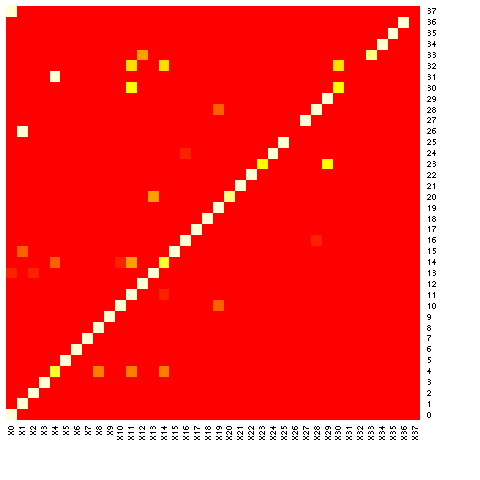

In [16]:
%%R -i conf_matrix

heatmap(as.matrix(conf_matrix), Rowv=NA, Colv=NA)

In [63]:
foo = conf_matrix.iloc[0:5, 0:5]
foo

,0,1,2,3,4
0,107,1,0,0,1
1,0,48,0,2,0
2,0,1,130,0,0
3,0,0,0,5,0
4,1,0,0,0,17


In [72]:
import numpy as np

foo = (conf_matrix / conf_matrix.sum())
np.diag(foo)

array([0.97272727, 0.92307692, 0.90909091, 0.55555556, 0.80952381,
       0.84615385, 0.83333333, 0.96153846, 0.63043478, 0.82857143,
       0.6       , 0.625     , 0.54166667, 0.7       , 0.66666667,
       0.63636364, 0.66666667, 0.5       , 0.57142857, 0.78378378,
       0.66666667, 0.66666667, 0.52941176, 0.66666667, 0.33333333])